![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    XGBoost gap-filling
</b>: extensive example, more parameters
</span>

---
**Notebook version**: `1` (26 Apr 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using [XGBoost](https://xgboost.readthedocs.io/en/stable/) to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f', 'SWC_FF0_0.15_1', 'PPFD']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

from diive.configs.exampledata import load_exampledata_parquet
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.createvar.daynightflag import DaytimeNighttimeFlag
from diive.pkgs.createvar.timesince import TimeSince
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS

warnings.filterwarnings('ignore')
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.0


</br>

# **Docstring** for `XGBoostTS`

In [3]:
# help(XGBoostTS)

</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
source_df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.040 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
df = source_df.copy()
lowquality = df[
                 "QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

## Add more features

In [6]:
# Calculate time since sub-zero air temperature
ts = TimeSince(df['Tair_f'], upper_lim=0, include_lim=True)
ts.calc()
ts_series = ts.get_timesince()
df['TA>0'] = ts_series

# Calculate time since air temperature was >= 20°C
ts = TimeSince(df['Tair_f'], lower_lim=20, include_lim=True)
ts.calc()
ts_series = ts.get_timesince()
# xxx = ts.get_full_results()
df['TA>20'] = ts_series

# Calculate daytime and nighttime flag
dnf = DaytimeNighttimeFlag(
    timestamp_index=df.index,
    nighttime_threshold=50,
    lat=46.815333,
    lon=9.855972,
    utc_offset=1)
results = dnf.get_results()
df['DAYTIME'] = results['DAYTIME'].copy()
df['NIGHTTIME'] = results['NIGHTTIME'].copy()

In [7]:
df

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f,SWC_FF0_0.15_1,PPFD,TA>0,TA>20,DAYTIME,NIGHTTIME
TIMESTAMP_MIDDLE,,,,,,,,,,
2013-01-01 00:15:00,NaN,-1.618,1.339,0.0,34.977,0.017,0,1,0.0,1.0
2013-01-01 00:45:00,NaN,-1.630,1.337,0.0,34.977,0.031,0,2,0.0,1.0
2013-01-01 01:15:00,NaN,-1.644,1.335,0.0,34.971,-0.006,0,3,0.0,1.0
2013-01-01 01:45:00,0.538,-1.657,1.332,0.0,34.975,-0.018,0,4,0.0,1.0
2013-01-01 02:15:00,NaN,-0.567,3.545,0.0,34.967,0.007,0,5,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,NaN,3.463,2.210,0.0,19.572,0.000,71,5241,0.0,1.0
2022-12-31 22:15:00,3.518,5.283,3.327,0.0,19.577,0.000,72,5242,0.0,1.0
2022-12-31 22:45:00,NaN,5.537,3.467,0.0,19.589,0.000,73,5243,0.0,1.0


In [8]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f,SWC_FF0_0.15_1,PPFD,TA>0,TA>20,DAYTIME,NIGHTTIME
count,41284.000000,175296.000000,175296.000000,175296.000000,164568.000000,175060.000000,175296.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445,23.909444,305.280529,1210.571211,4501.219229,0.480969,0.519031
std,6.085449,7.548653,3.710180,247.531312,4.890167,494.128310,1860.740670,4086.748021,0.499639,0.499639
min,-38.653000,-23.096000,0.000000,0.000000,12.436000,-2.707000,0.000000,0.000000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000,20.748000,0.000000,0.000000,430.000000,0.000000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000,24.496000,9.721000,119.000000,3655.000000,0.000000,1.000000
75%,0.606250,10.067000,4.375000,225.677750,27.106000,449.168500,1895.000000,7881.250000,1.000000,1.000000
max,25.290000,28.713000,32.118000,1197.800000,41.451000,2420.772000,7853.000000,13386.000000,1.000000,1.000000


In [9]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
MEDIAN,-3.827
SD,6.085449
VAR,37.032694


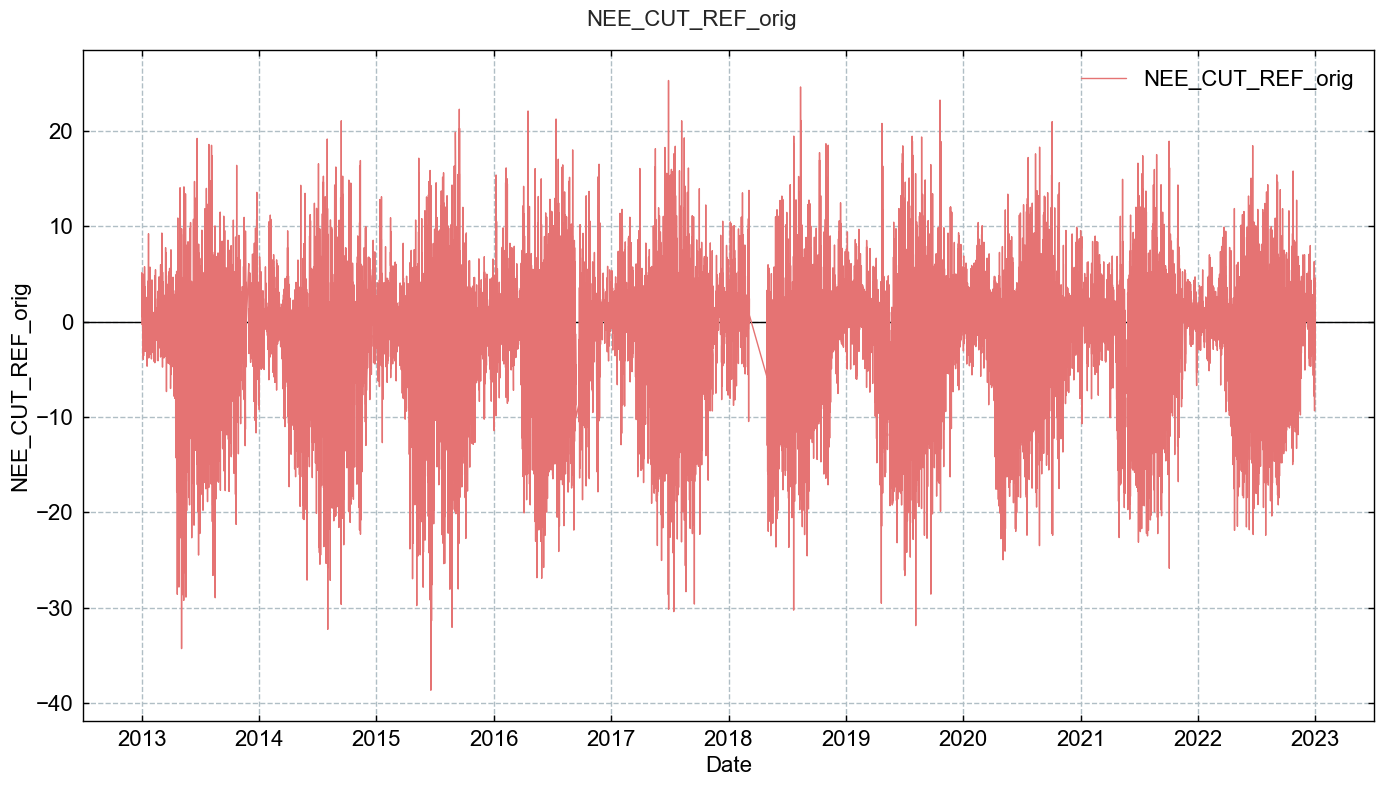

In [10]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize XGBoost

In [11]:
xgbts = XGBoostTS(
    input_df=df,
    target_col=TARGET_COL,
    verbose=1,
    features_lag=[-1, -1],
    features_lag_exclude_cols=['Rg_f', 'TA>0', 'TA>20', 'DAYTIME', 'NIGHTTIME'],
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    sanitize_timestamp=True,
    perm_n_repeats=9,
    n_estimators=99,
    random_state=42,
    validate_parameters=True,
    early_stopping_rounds=10,
    max_depth=6,
    learning_rate=0.3,
    tree_method='auto',  # auto, hist, approx, exact
    n_jobs=-1
)



Starting gap-filling for
NEE_CUT_REF_orig
using <class 'xgboost.sklearn.XGBRegressor'>

Adding new data columns ...
++ Added new columns with lagged variants for: ['Tair_f', 'VPD_f', 'SWC_FF0_0.15_1', 'PPFD'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['NEE_CUT_REF_orig', 'Rg_f', 'TA>0', 'TA>20', 'DAYTIME', 'NIGHTTIME']. Shifting the time series created gaps which were then filled with the nearest value.
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no d

</br>

## Feature reduction

In [12]:
xgbts.reduce_features()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:4.94685	validation_1-rmse:4.94685
[1]	validation_0-rmse:4.24280	validation_1-rmse:4.24280
[2]	validation_0-rmse:3.82051	validation_1-rmse:3.82051
[3]	validation_0-rmse:3.57057	validation_1-rmse:3.57057
[4]	validation_0-rmse:3.42182	validation_1-rmse:3.42182
[5]	validation_0-rmse:3.31961	validation_1-rmse:3.31961
[6]	validation_0-rmse:3.25561	validation_1-rmse:3.25561
[7]	validation_0-rmse:3.21661	validation_1-rmse:3.21661
[8]	validation_0-rmse:3.17086	validation_1-rmse:3.17086
[9]	validation_0-rmse:3.13975	validation_1-rmse:3.13975
[10]	validation_0-rmse:3.11710	validation_1-rmse:3.11710
[11]	validation_0-rmse:3.08843	validation_1-rmse:3.08843
[12]	validation_0-rmse:3.06546	validation_1-rmse:3.06546
[13]	validation_0-rmse:3.05074	validation_1-rmse:3.05074
[14]	validation_0-rmse:3.03840	validation_1-rmse:3.03840
[15]	validation_0-rmse:3.02668	validation_1-rmse:3.02668
[16]	validation_0-rmse:3.01537	validation_1

In [13]:
xgbts.report_feature_reduction()


FEATURE REDUCTION

- Target variable: NEE_CUT_REF_orig

- The random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances.

PERMUTATION IMPORTANCE (mean) across all splits of TimeSeriesSplit:

                   PERM_IMPORTANCE   PERM_SD
PPFD                      0.557329  0.004876
.Tair_f-1                 0.353138  0.002542
Tair_f                    0.276424  0.001458
Rg_f                      0.237743  0.000989
.VPD_f-1                  0.224040  0.001561
.PPFD-1                   0.127260  0.001485
.DOY                      0.125497  0.001171
TA>0                      0.107954  0.000799
VPD_f                     0.091838  0.001188
.HOUR                     0.083771  0.000684
TA>20                     0.057840  0.000423
SWC_FF0_0.15_1            0.049570  0.000770
.SWC_FF0_0.15_1-1         0.032152  0.000600
.YEARDOY                  0.029217  0.000699
.WEEK                     0.027984  0.000511
.YEARMONTH               

</br>

## Train model


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2013-01-01 01:45:00 and 2022-12-31 22:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:4.94754	validation_1-rmse:4.95399
[1]	validation_0-rmse:4.24355	validation_1-rmse:4.26082
[2]	validation_0-rmse:3.82069	validation_1-rmse:3.85510
[3]	validation_0-rmse:3.56964	validation_1-rmse:3.61843
[4]	validation_0-rmse:3.42108	validation_1-rmse:3.48243
[5]	validation_0-rmse:3.31823	validation_1-rmse:3.39396
[6]	validation_0-rmse:3.25490	validation_1-rmse:3.34453
[7]	validation_0-rmse:3.21474	validation_1-rmse:3.31608
[8]	validation_0-rmse:3.16974	validation_1-rmse:3.28488
[9]	validation_0-rmse:3.13810	validation_1-rmse:3.26913
[10]	validation_0-rmse:3.11069	validation_1-rmse:3.25828
[11]	validation_0-rmse:3.08105	validation_1-rmse:3.24406
[12]	validation_0-rmse:3.05541	validation_1-rmse:3.23696
[13]	validation_0-rmse:3.03386	validation_1-rmse:3.22818
[14]	validation_0-r

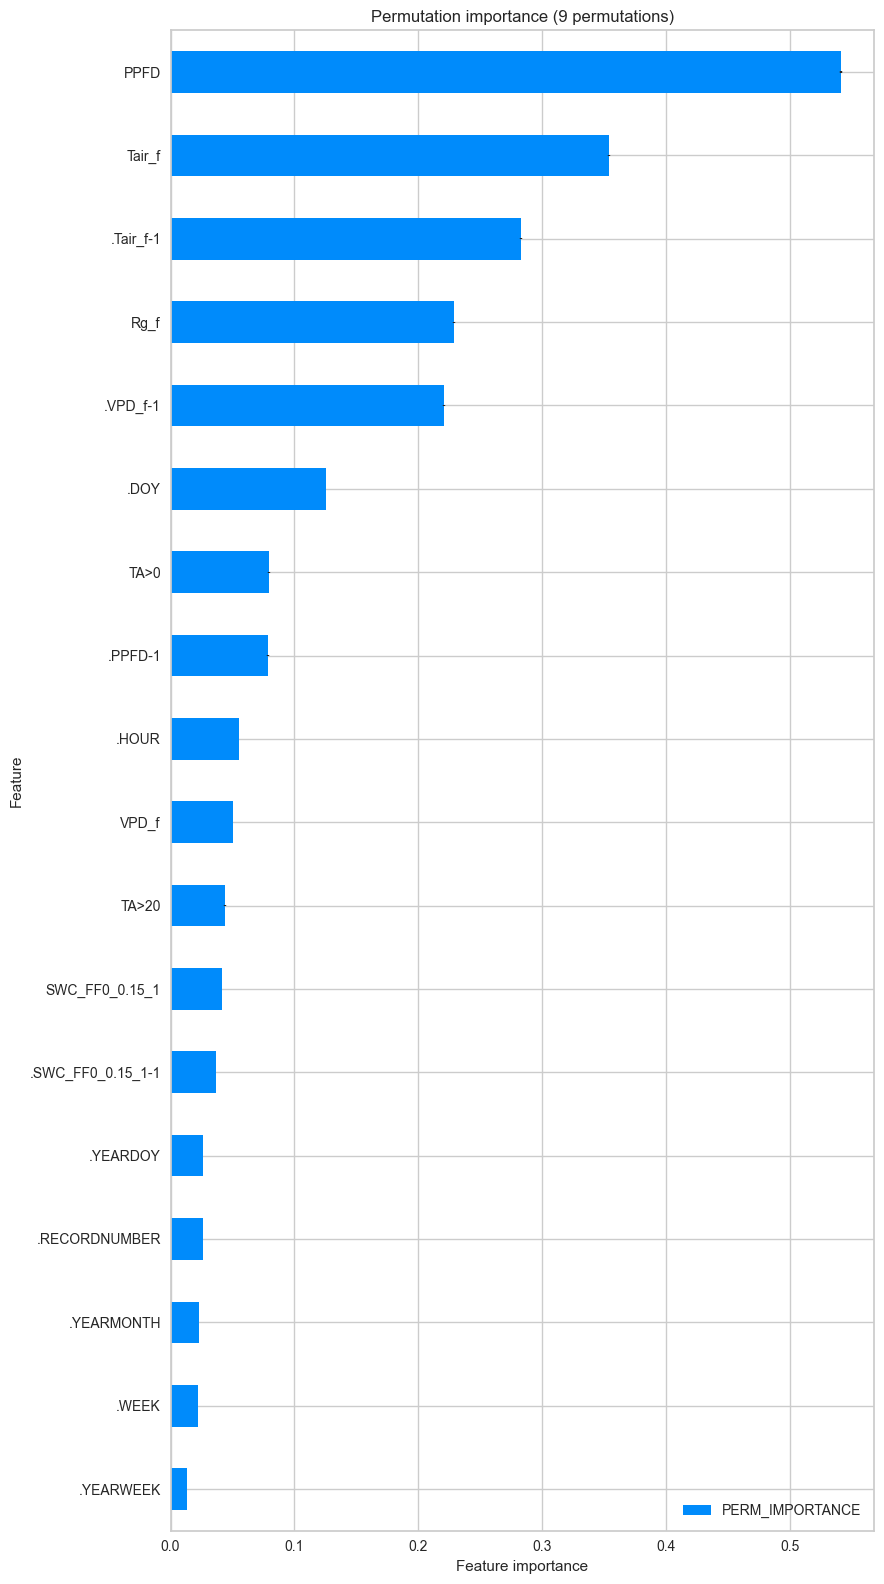

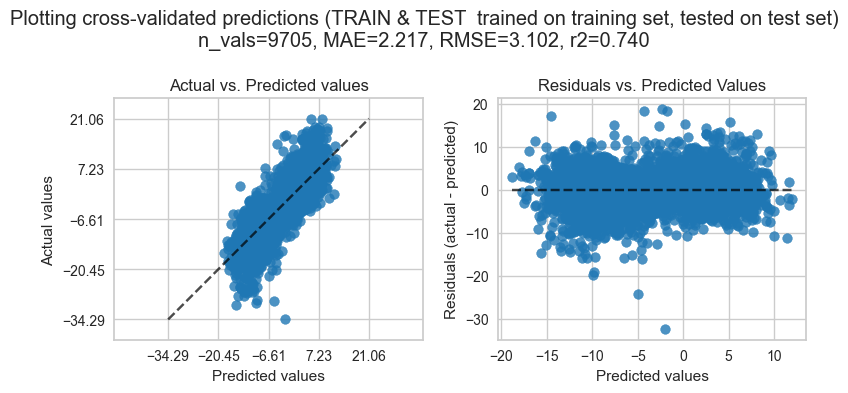

>>> Plotting residuals and prediction error ...


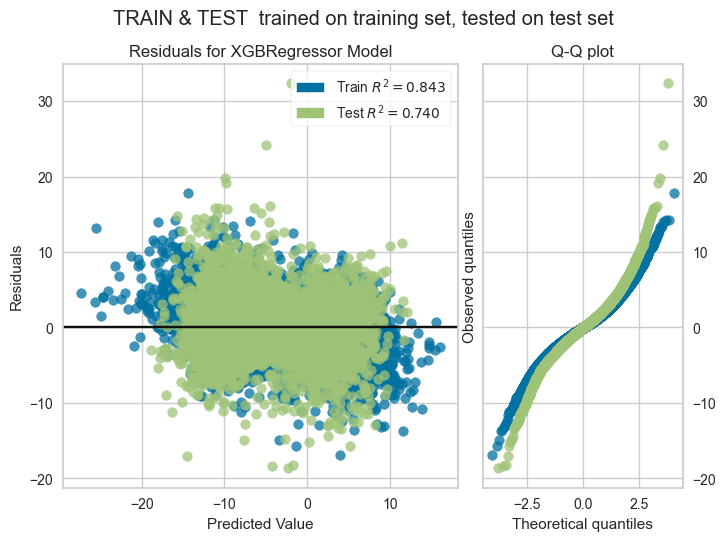

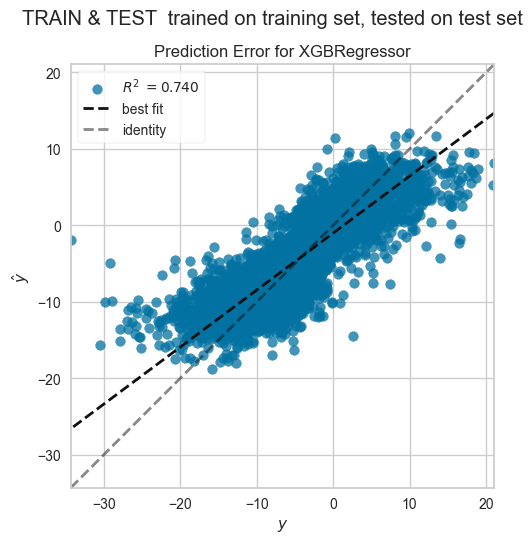

>>> Collecting results, details about training and testing can be accessed by calling .report_traintest().
>>> Done.


In [14]:
xgbts.trainmodel(showplot_scores=True, showplot_importance=True)

In [15]:
xgbts.report_traintest()


MODEL TRAINING & TESTING RESULTS

## DATA
  > target: NEE_CUT_REF_orig
  > features: 18 ['PPFD', '.Tair_f-1', 'Tair_f', 'Rg_f', '.VPD_f-1', '.PPFD-1', '.DOY', 'TA>0', 'VPD_f', '.HOUR', 'TA>20', 'SWC_FF0_0.15_1', '.SWC_FF0_0.15_1-1', '.YEARDOY', '.WEEK', '.YEARMONTH', '.YEARWEEK', '.RECORDNUMBER']
  > 175296 records (with missing)
  > 38820 available records for target and all features (no missing values)
  > training on 29115 records (75.0%) of 29115 features between 2013-01-01 01:45:00 and 2022-12-31 22:15:00
  > testing on 9705 unseen records (25.0%) of NEE_CUT_REF_orig between 2013-01-02 12:15:00 and 2022-12-31 13:15:00

## MODEL
  > the model was trained on training data (29115 records)
  > the model was tested on test data (9705 values)
  > estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=Fals

</br>

## Apply model to fill gaps


Gap-filling using final model ...
>>> Using final model on all data to predict target NEE_CUT_REF_orig ...
>>> Using final model on all data to calculate permutation importance ...
>>> Plotting feature importances (permutation importance) ...
>>> Calculating prediction scores based on all data predicting NEE_CUT_REF_orig ...
>>> Plotting observed and predicted values based on all data ...


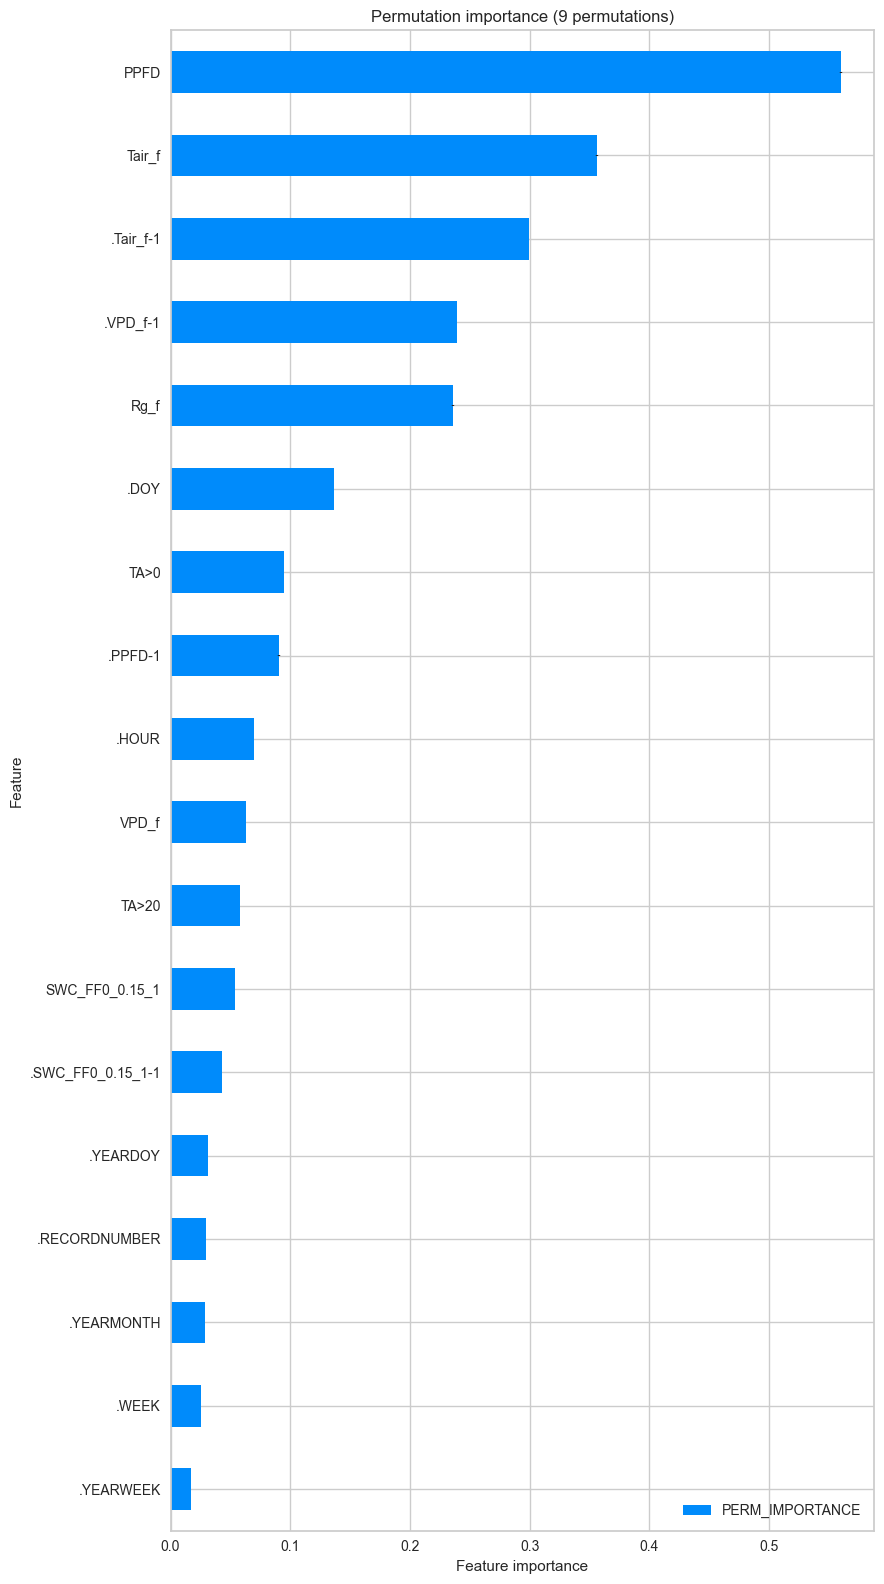

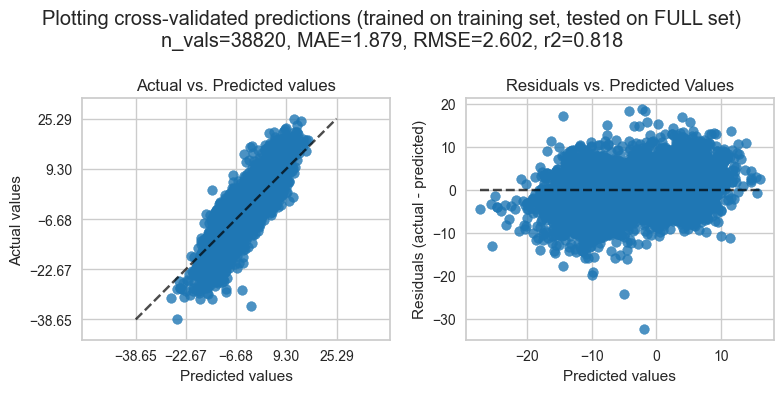

>>> Predicting target NEE_CUT_REF_orig where all features are available ... predicted 162851 records.
>>> Collecting results for final model ...
>>> Filling 124031 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable NEE_CUT_REF_orig_gfXG ...
>>> Restoring original timestamp in results ...

Gap-filling 12445 remaining missing records in NEE_CUT_REF_orig_gfXG using fallback model ...
>>> Fallback model is trained on NEE_CUT_REF_orig_gfXG and timestamp info ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] (ONLY FALLBACK)
[0]	validation_0-rmse:3.94005	validation_1-rmse:3.94005
[1]	validation_0-rmse:3.30968	validation_1-rmse:3.30968
[2]	validation_0-rmse:2.93609	validation_1-rmse:2.93609
[3]	validation_0-rmse:2.70404	validation_1-rmse:2.70404
[4]	validation_0-rmse:2.57591	validation_1-rmse:2.57591
[5]	validation_0-rmse:2.49299	validation_1-r

In [16]:
xgbts.fillgaps(showplot_scores=True, showplot_importance=True)

In [17]:
xgbts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (124031 values, NEE_CUT_REF_orig_gfXG where flag=1) in comparison to observed targets (38820 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  136476 (cross-check from flag: 136476)
- target column (gap-filled):  NEE_CUT_REF_orig_gfXG  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED
  > flag 0 ... observed targets (38820 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (124031 values)
  > flag 2 ... targets gap-filled with fallback (12445 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['PPFD', 'Tair_f', '.Tair_f-1', '.VPD_f-1', 'Rg_f', '.DOY', 'TA>0', '.PPFD-1', '.HOUR', 'VPD_f'

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [18]:
xgbts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
PPFD,0.559632,0.006025
Tair_f,0.356234,0.004033
.Tair_f-1,0.299577,0.003097
.VPD_f-1,0.239572,0.003148
Rg_f,0.236221,0.002999
.DOY,0.136851,0.001959
TA>0,0.094871,0.000590
.PPFD-1,0.090797,0.001089
.HOUR,0.070017,0.000841
VPD_f,0.063122,0.001052


In [19]:
xgbts.feature_importances_reduction_

,PERM_IMPORTANCE,PERM_SD
PPFD,0.557329,0.004876
.Tair_f-1,0.353138,0.002542
Tair_f,0.276424,0.001458
Rg_f,0.237743,0.000989
.VPD_f-1,0.224040,0.001561
.PPFD-1,0.127260,0.001485
.DOY,0.125497,0.001171
TA>0,0.107954,0.000799
VPD_f,0.091838,0.001188
.HOUR,0.083771,0.000684


In [20]:
xgbts.feature_importances_traintest_

,PERM_IMPORTANCE,PERM_SD
PPFD,0.540440,0.009904
Tair_f,0.353652,0.006813
.Tair_f-1,0.282627,0.005541
Rg_f,0.228930,0.005491
.VPD_f-1,0.220916,0.005502
.DOY,0.125493,0.003511
TA>0,0.079606,0.003743
.PPFD-1,0.079019,0.002611
.HOUR,0.055013,0.001548
VPD_f,0.050195,0.002704


In [21]:
xgbts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED,NEE_CUT_REF_orig_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,2.787463,2.787463,2.787463,2.787463
2013-01-01 00:45:00,0.985575,NaN,0.985575,1.0,0.985575,2.787463,3.773039,0.985575
2013-01-01 01:15:00,0.962556,NaN,0.962556,1.0,0.962556,2.434434,4.735595,0.962556
2013-01-01 01:45:00,0.962556,0.538,NaN,0.0,0.538000,2.434434,5.273595,0.962556
2013-01-01 02:15:00,0.189135,NaN,0.189135,1.0,0.189135,2.547381,5.462730,0.189135
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,1.103891,NaN,1.103891,1.0,1.103891,1.008535,-60210.219053,1.103891
2022-12-31 22:15:00,0.887848,3.518,NaN,0.0,3.518000,0.881409,-60206.701053,0.887848
2022-12-31 22:45:00,1.372834,NaN,1.372834,1.0,1.372834,0.881409,-60205.328219,1.372834


In [22]:
xgbts.model_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=99, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
xgbts.accepted_features_

['PPFD',
 '.Tair_f-1',
 'Tair_f',
 'Rg_f',
 '.VPD_f-1',
 '.PPFD-1',
 '.DOY',
 'TA>0',
 'VPD_f',
 '.HOUR',
 'TA>20',
 'SWC_FF0_0.15_1',
 '.SWC_FF0_0.15_1-1',
 '.YEARDOY',
 '.WEEK',
 '.YEARMONTH',
 '.YEARWEEK',
 '.RECORDNUMBER']

In [24]:
xgbts.rejected_features_

['DAYTIME', 'NIGHTTIME', '.YEAR', '.SEASON', '.MONTH']

In [25]:
xgbts.scores_

{'mae': np.float64(1.8787095489755732),
 'medae': np.float64(1.381306441307068),
 'mse': np.float64(6.770926233116245),
 'rmse': np.float64(2.6021003503163063),
 'mape': np.float64(478293261473.01245),
 'maxe': np.float64(32.3325806980133),
 'r2': 0.8176372023892216}

In [26]:
xgbts.scores_traintest_

{'mae': np.float64(2.2167264512445635),
 'medae': np.float64(1.61627854013443),
 'mse': np.float64(9.625367021995897),
 'rmse': np.float64(3.102477561884356),
 'mape': np.float64(703960629136.4734),
 'maxe': np.float64(32.3325806980133),
 'r2': 0.7403221349185757}

In [27]:
xgbts.traintest_details_.keys()

dict_keys(['train_df', 'test_df', 'test_size', 'X_names', 'model'])

</br>

## Result

In [28]:
gapfilled = xgbts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    2.787463
2013-01-01 00:45:00    0.985575
2013-01-01 01:15:00    0.962556
2013-01-01 01:45:00    0.538000
2013-01-01 02:15:00    0.189135
                         ...   
2022-12-31 21:45:00    1.103891
2022-12-31 22:15:00    3.518000
2022-12-31 22:45:00    1.372834
2022-12-31 23:15:00    2.083800
2022-12-31 23:45:00    0.502623
Freq: 30min, Name: NEE_CUT_REF_orig_gfXG, Length: 175296, dtype: float64

In [29]:
flag = xgbts.get_flag()
flag

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    2.0
2013-01-01 00:45:00    1.0
2013-01-01 01:15:00    1.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    1.0
                      ... 
2022-12-31 21:45:00    1.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    1.0
2022-12-31 23:15:00    1.0
2022-12-31 23:45:00    1.0
Freq: 30min, Name: FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED, Length: 175296, dtype: float64

In [30]:
gapfilling_df = xgbts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED,NEE_CUT_REF_orig_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,2.787463,2.787463,2.787463,2.787463
2013-01-01 00:45:00,0.985575,NaN,0.985575,1.0,0.985575,2.787463,3.773039,0.985575
2013-01-01 01:15:00,0.962556,NaN,0.962556,1.0,0.962556,2.434434,4.735595,0.962556
2013-01-01 01:45:00,0.962556,0.538,NaN,0.0,0.538000,2.434434,5.273595,0.962556
2013-01-01 02:15:00,0.189135,NaN,0.189135,1.0,0.189135,2.547381,5.462730,0.189135
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,1.103891,NaN,1.103891,1.0,1.103891,1.008535,-60210.219053,1.103891
2022-12-31 22:15:00,0.887848,3.518,NaN,0.0,3.518000,0.881409,-60206.701053,0.887848
2022-12-31 22:45:00,1.372834,NaN,1.372834,1.0,1.372834,0.881409,-60205.328219,1.372834


</br>

## Plot

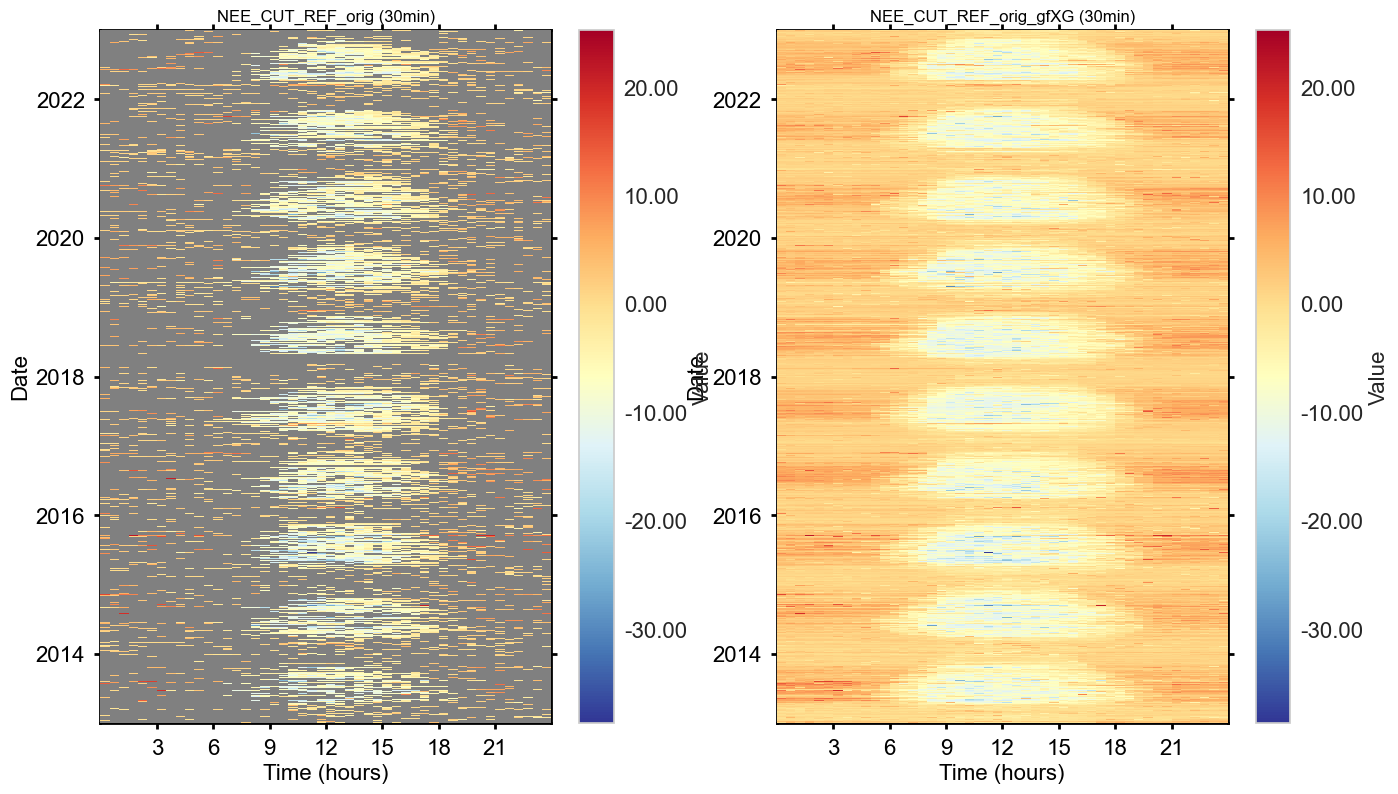

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

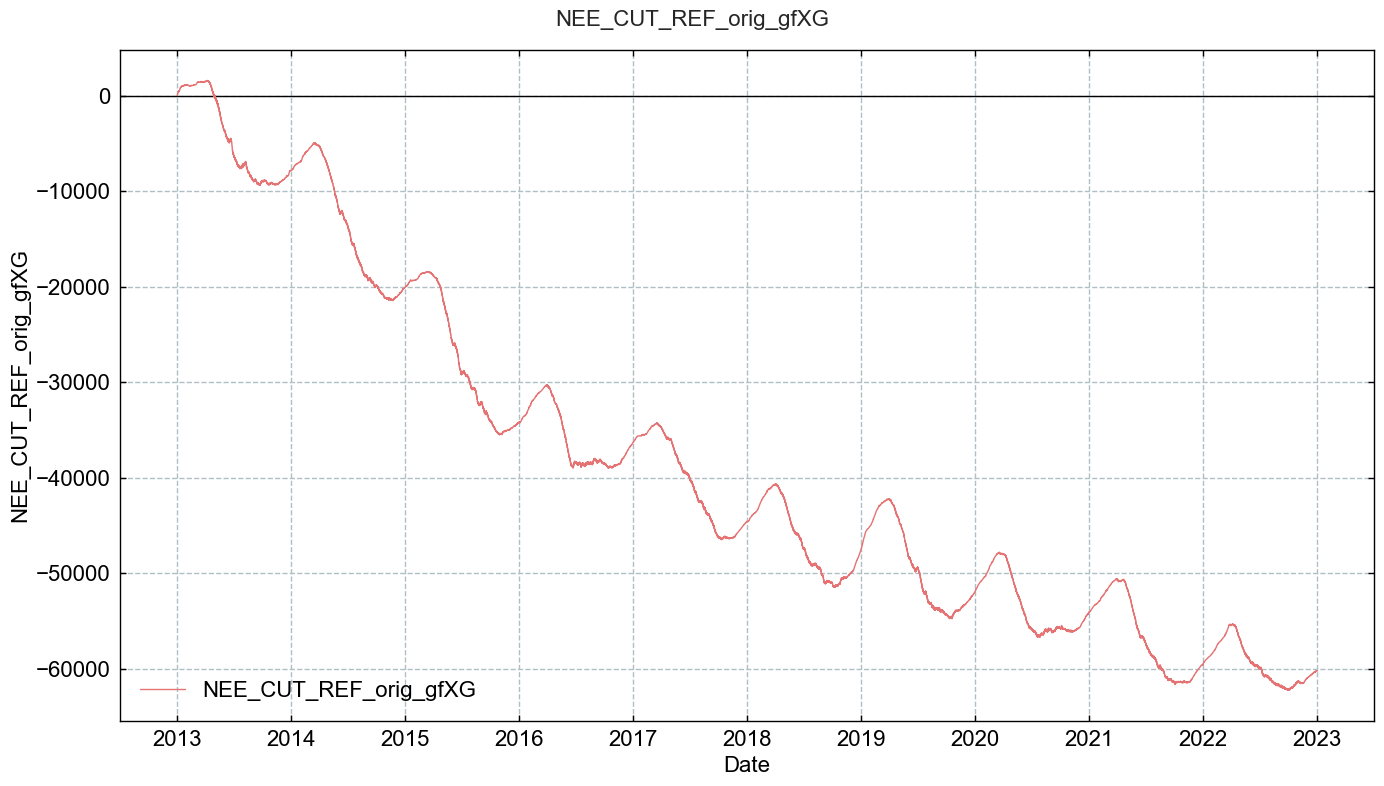

In [32]:
TimeSeries(gapfilled.cumsum()).plot();

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [33]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-01-23 22:21:36
